# Methods of discretizing a surface for forward modelling

## import packages

In [8]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

# local python scripts
import numpy as np
import verde as vd
import xarray as xr
from polartoolkit import fetch, maps, regions, utils

import RIS_gravity_inversion.utils as inv_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we show that the calculated forward gravity across a single density contrast (below Fig. a) can be modelled in three ways:
1) Fig. b) as 2 prism layers with absolute densities.
2) Fig. c-d) as 1 prism layer with density relative to the material on the other side of the contrast, or 
3) Fig. e) with prisms of positive or negative density contrast, depending on their position relative to a reference level.
<img src="../figures/absolute_vs_density_contrasts_1surface.svg" width="1000"/>

## Get sample data

Bed from Bedmap2

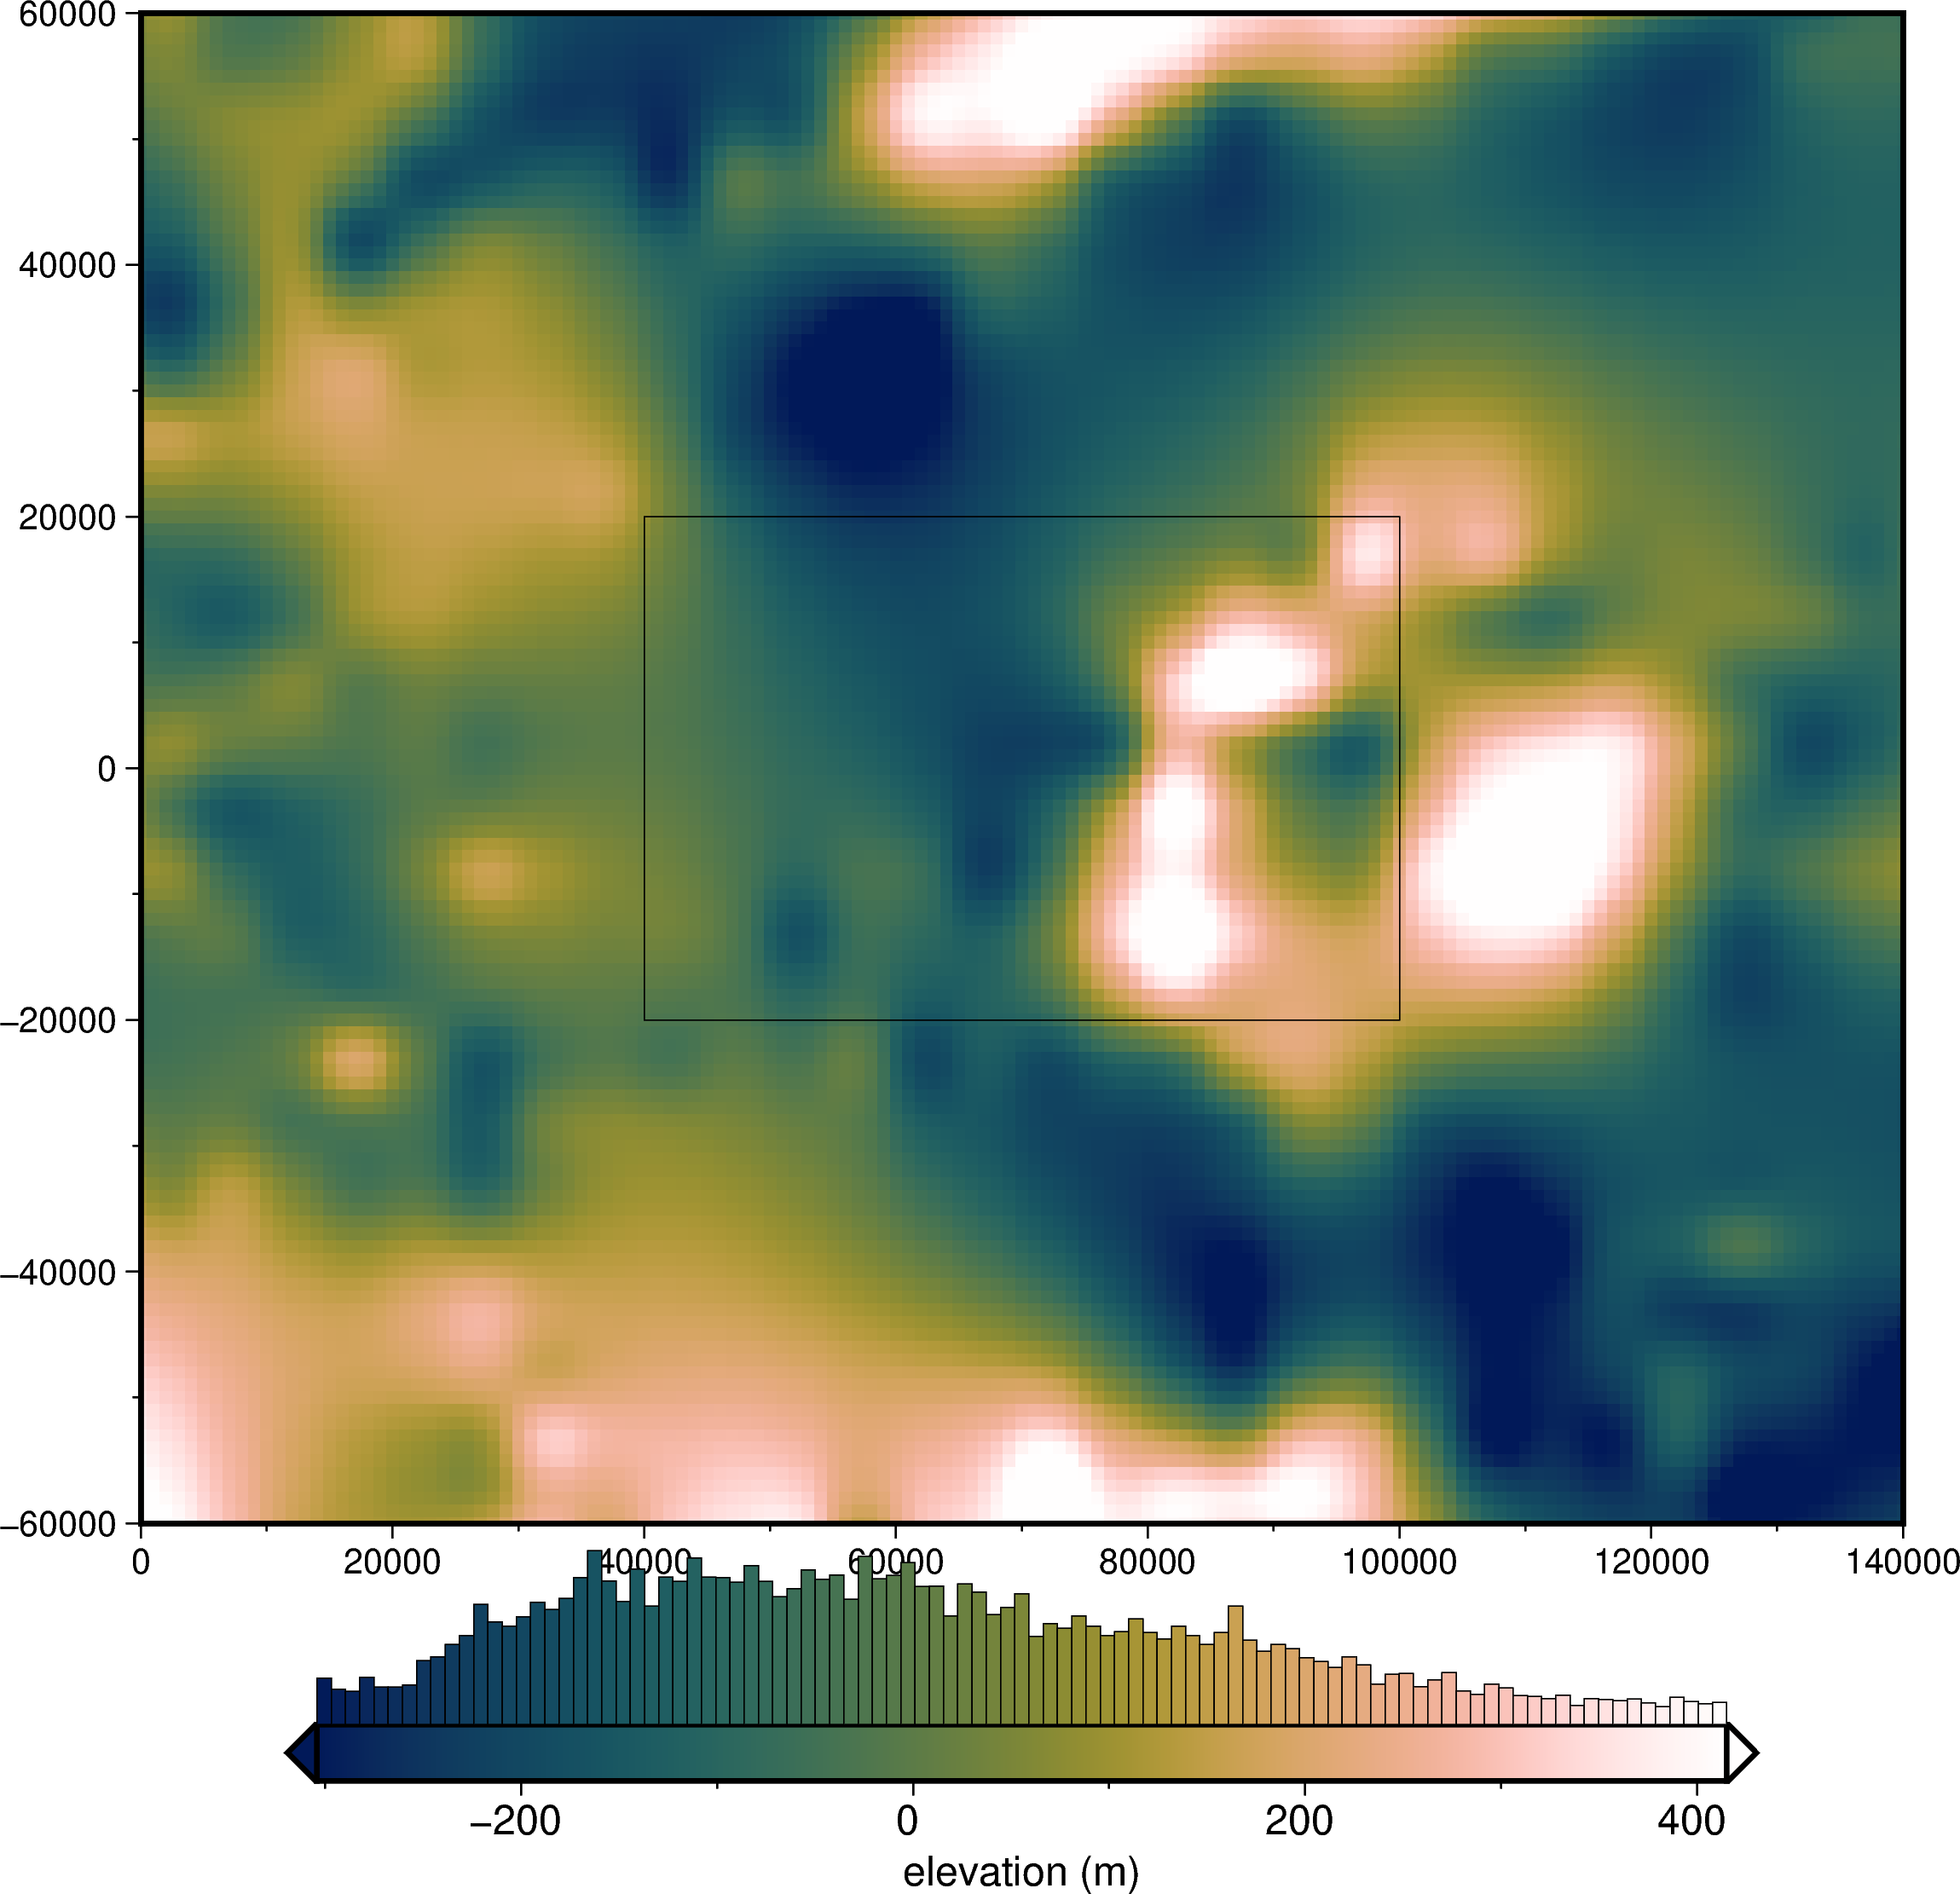

(1000.0, (0.0, 140000.0, -60000.0, 60000.0), -390.0, 612.0, 'g')

In [10]:
spacing = 1e3

inner_region = [40e3, 100e3, -20e3, 20e3]

buffer_region = regions.alter_region(inner_region, zoom=-40e3)

bed = fetch.bedmap2(
    layer="bed",
    region=buffer_region,
    spacing=spacing,
)

fig = maps.plot_grd(
    bed,
    inset=False,
    titles="Bed",
    cbar_label="elevation (m)",
    show_region=inner_region,
    region=buffer_region,
    cmap="batlowW",
    hist=True,
    robust=True,
    frame=True,
)

fig.show()

utils.get_grid_info(bed)

## create observation points

In [11]:
coords = vd.grid_coordinates(
    inner_region,
    spacing=spacing * 2,
    extra_coords=3e3,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

# observations = fetch.resample_grid(observations, region=inversion_region, registration=registration)
print(utils.get_grid_info(observations))

observation_points = vd.grid_to_table(observations)
observation_points

(2000.0, (40000.0, 100000.0, -20000.0, 20000.0), 3000.0, 3000.0, 'g')


,northing,easting,upward
0,-20000.0,40000.0,3000.0
1,-20000.0,42000.0,3000.0
2,-20000.0,44000.0,3000.0
3,-20000.0,46000.0,3000.0
4,-20000.0,48000.0,3000.0
...,...,...,...
646,20000.0,92000.0,3000.0
647,20000.0,94000.0,3000.0
648,20000.0,96000.0,3000.0
649,20000.0,98000.0,3000.0


# Method b) Absolute Densities

In [5]:
ice_prisms = inv_utils.grids_to_prisms(
    bed,
    bed.values.max(),
    density=917,
    input_coord_names=["x", "y"],
)

bed_prisms = inv_utils.grids_to_prisms(
    bed,
    bed.values.min(),
    density=2670,
    input_coord_names=["x", "y"],
)

# plotting.show_prism_layers(
#     [ice_prisms, bed_prisms],
#     cmap="viridis",
#     # color_by="density",
#     # color_by="thickness",
#     color_by="constant",
#     clip_box=False,
#     zscale=20,
#     # backend='client',
# )

AttributeError: module 'RIS_gravity_inversion.utils' has no attribute 'grids_to_prisms'

  0%|                                                   | 0/651 [00:00<?, ?it/s]

  0%|                                                   | 0/651 [00:00<?, ?it/s]

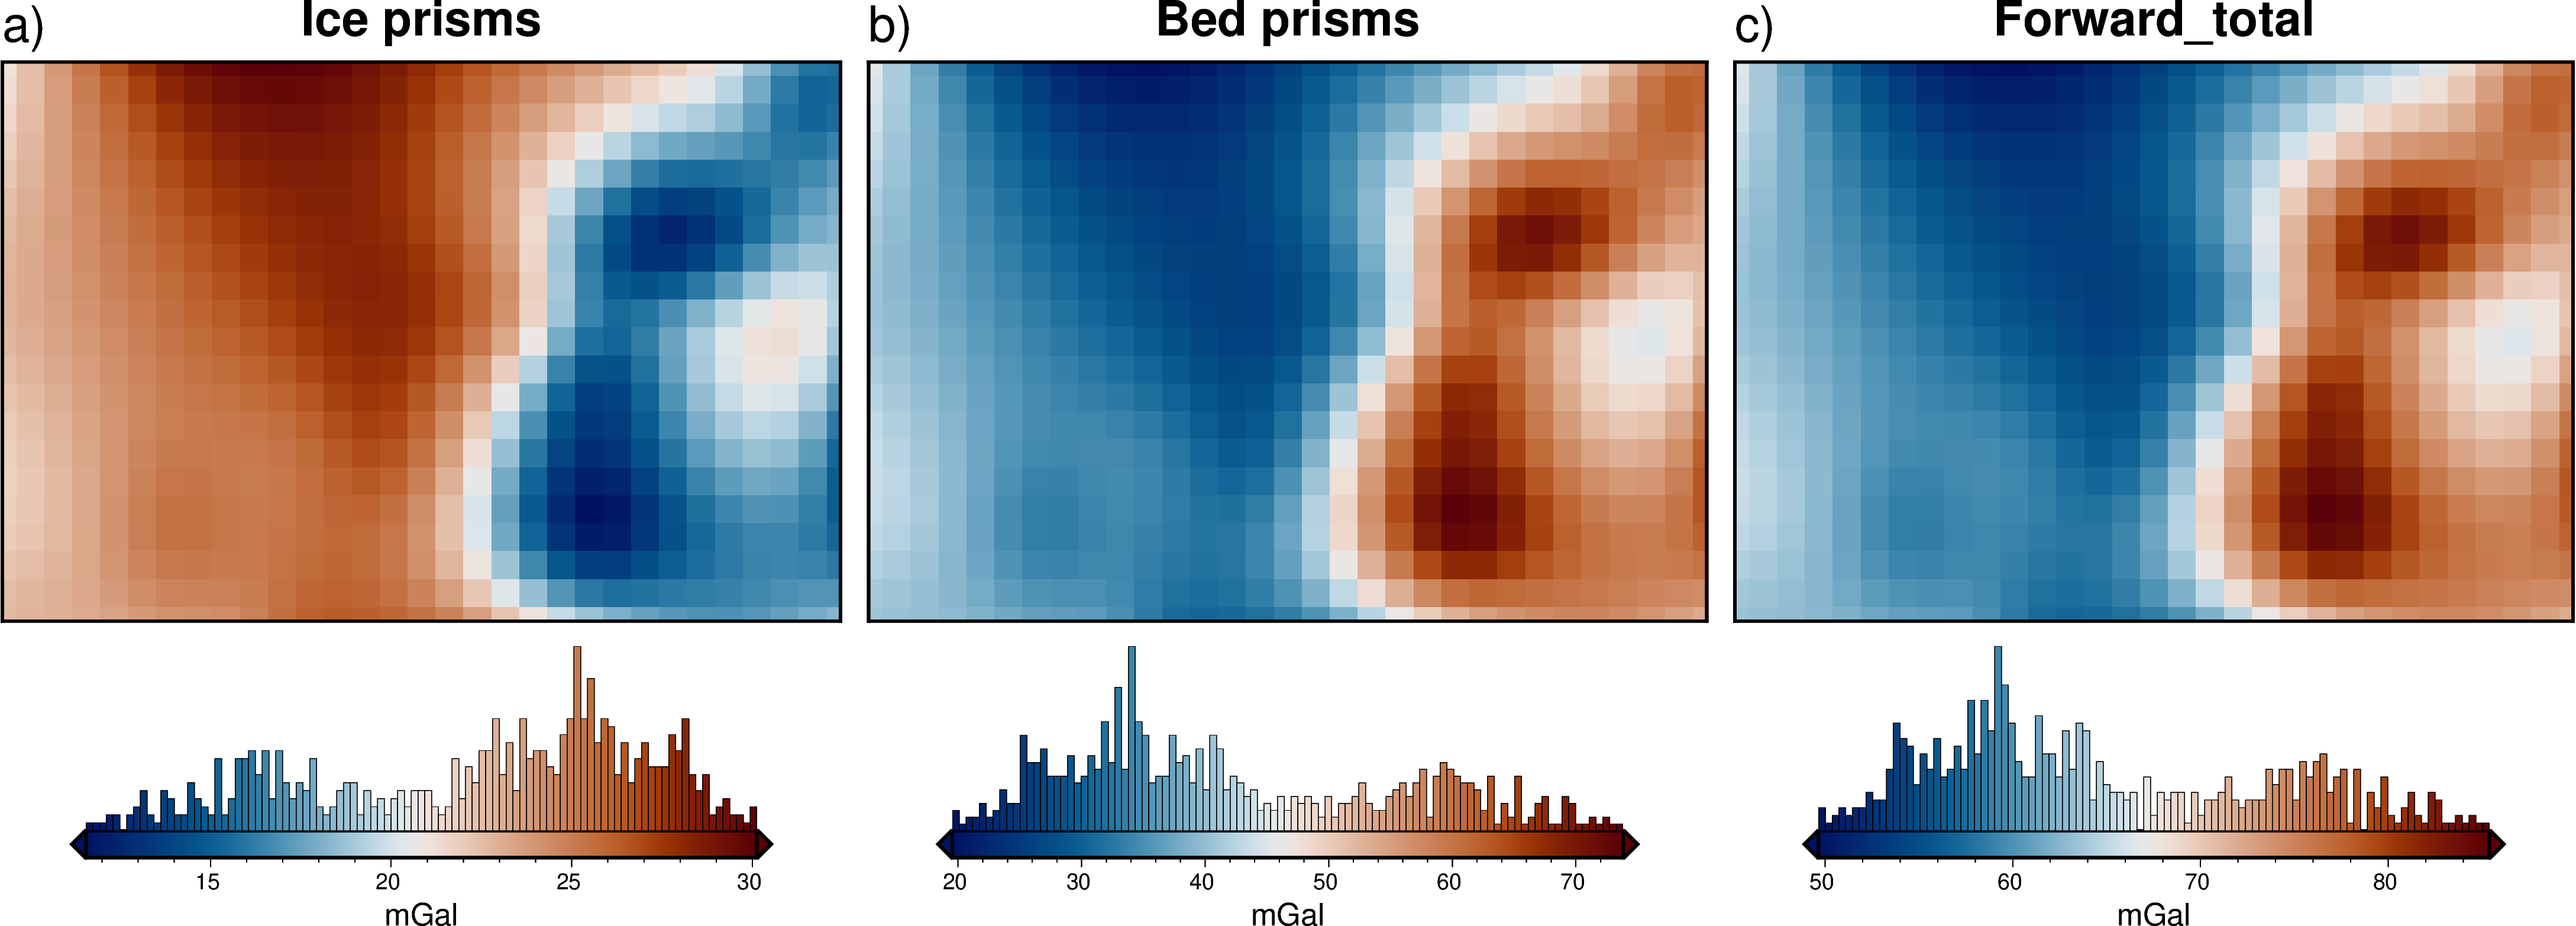

In [ ]:
forward_absolute, df = inv_utils.forward_grav_of_prismlayer(
    [ice_prisms, bed_prisms],
    observation_points,
    plot=True,
    names=["Ice prisms", "Bed prisms"],
    # remove_mean=True,
    progressbar=True,
)

# Method c) Prisms above surface; $\rho_{ice} - \rho_{rock}$

In [ ]:
prisms_above_surface = inv_utils.grids_to_prisms(
    bed,
    bed.values.max(),
    density=917 - 2670,
    input_coord_names=["x", "y"],
)

# plotting.show_prism_layers(
#     [prisms_relative_to_rock],
#     cmap="viridis",
#     # color_by="density",
#     # color_by="thickness",
#     color_by="constant",
#     # log_scale=False,
#     clip_box=False,
#     zscale=20,
# )

  0%|                                                   | 0/651 [00:00<?, ?it/s]

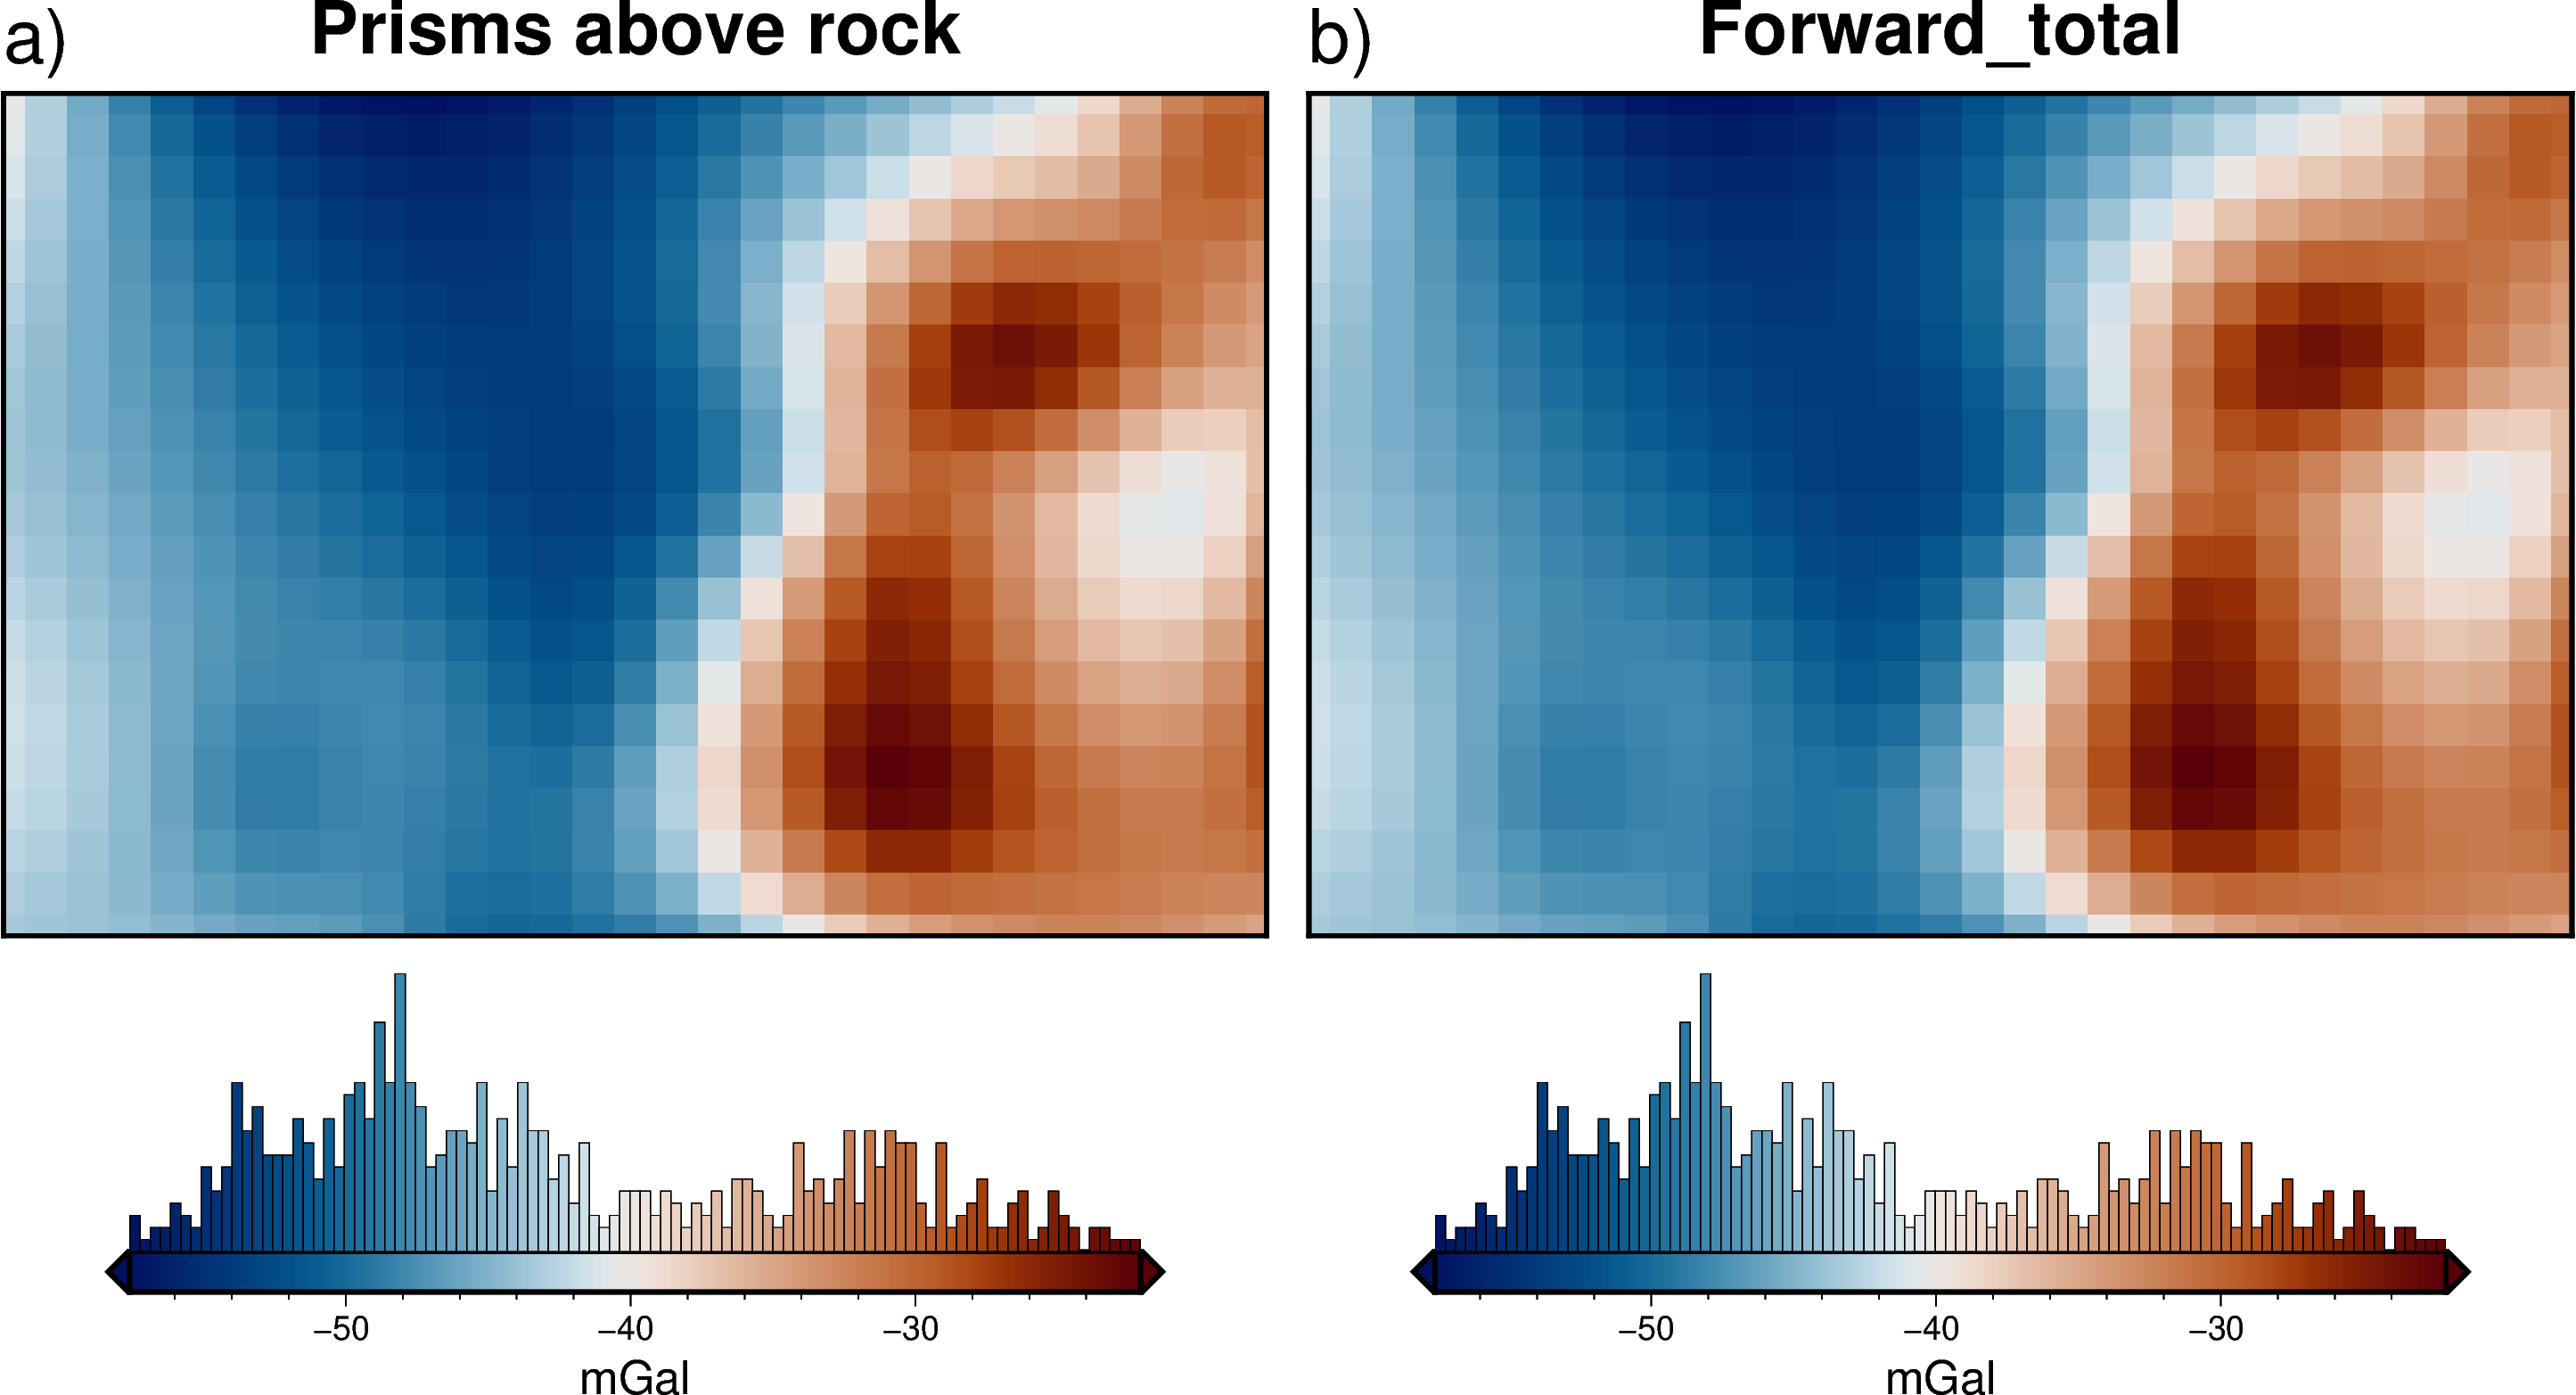

In [ ]:
grav_prisms_above_surface, df = inv_utils.forward_grav_of_prismlayer(
    [prisms_above_surface],
    observation_points,
    plot=True,
    names=["Prisms above rock"],
    # remove_mean=True,
    progressbar=True,
)

# Method d) Prisms below surface; $\rho_{rock} - \rho_{ice}$

In [ ]:
prisms_below_surface = inv_utils.grids_to_prisms(
    bed,
    bed.values.min(),
    density=2670 - 917,
    input_coord_names=["x", "y"],
)

# plotting.show_prism_layers(
#     [prisms_relative_to_ice],
#     cmap="viridis",
#     # color_by="density",
#     # color_by="thickness",
#     color_by="constant",
#     # log_scale=False,
#     clip_box=False,
#     zscale=20,
# )

  0%|                                                   | 0/651 [00:00<?, ?it/s]

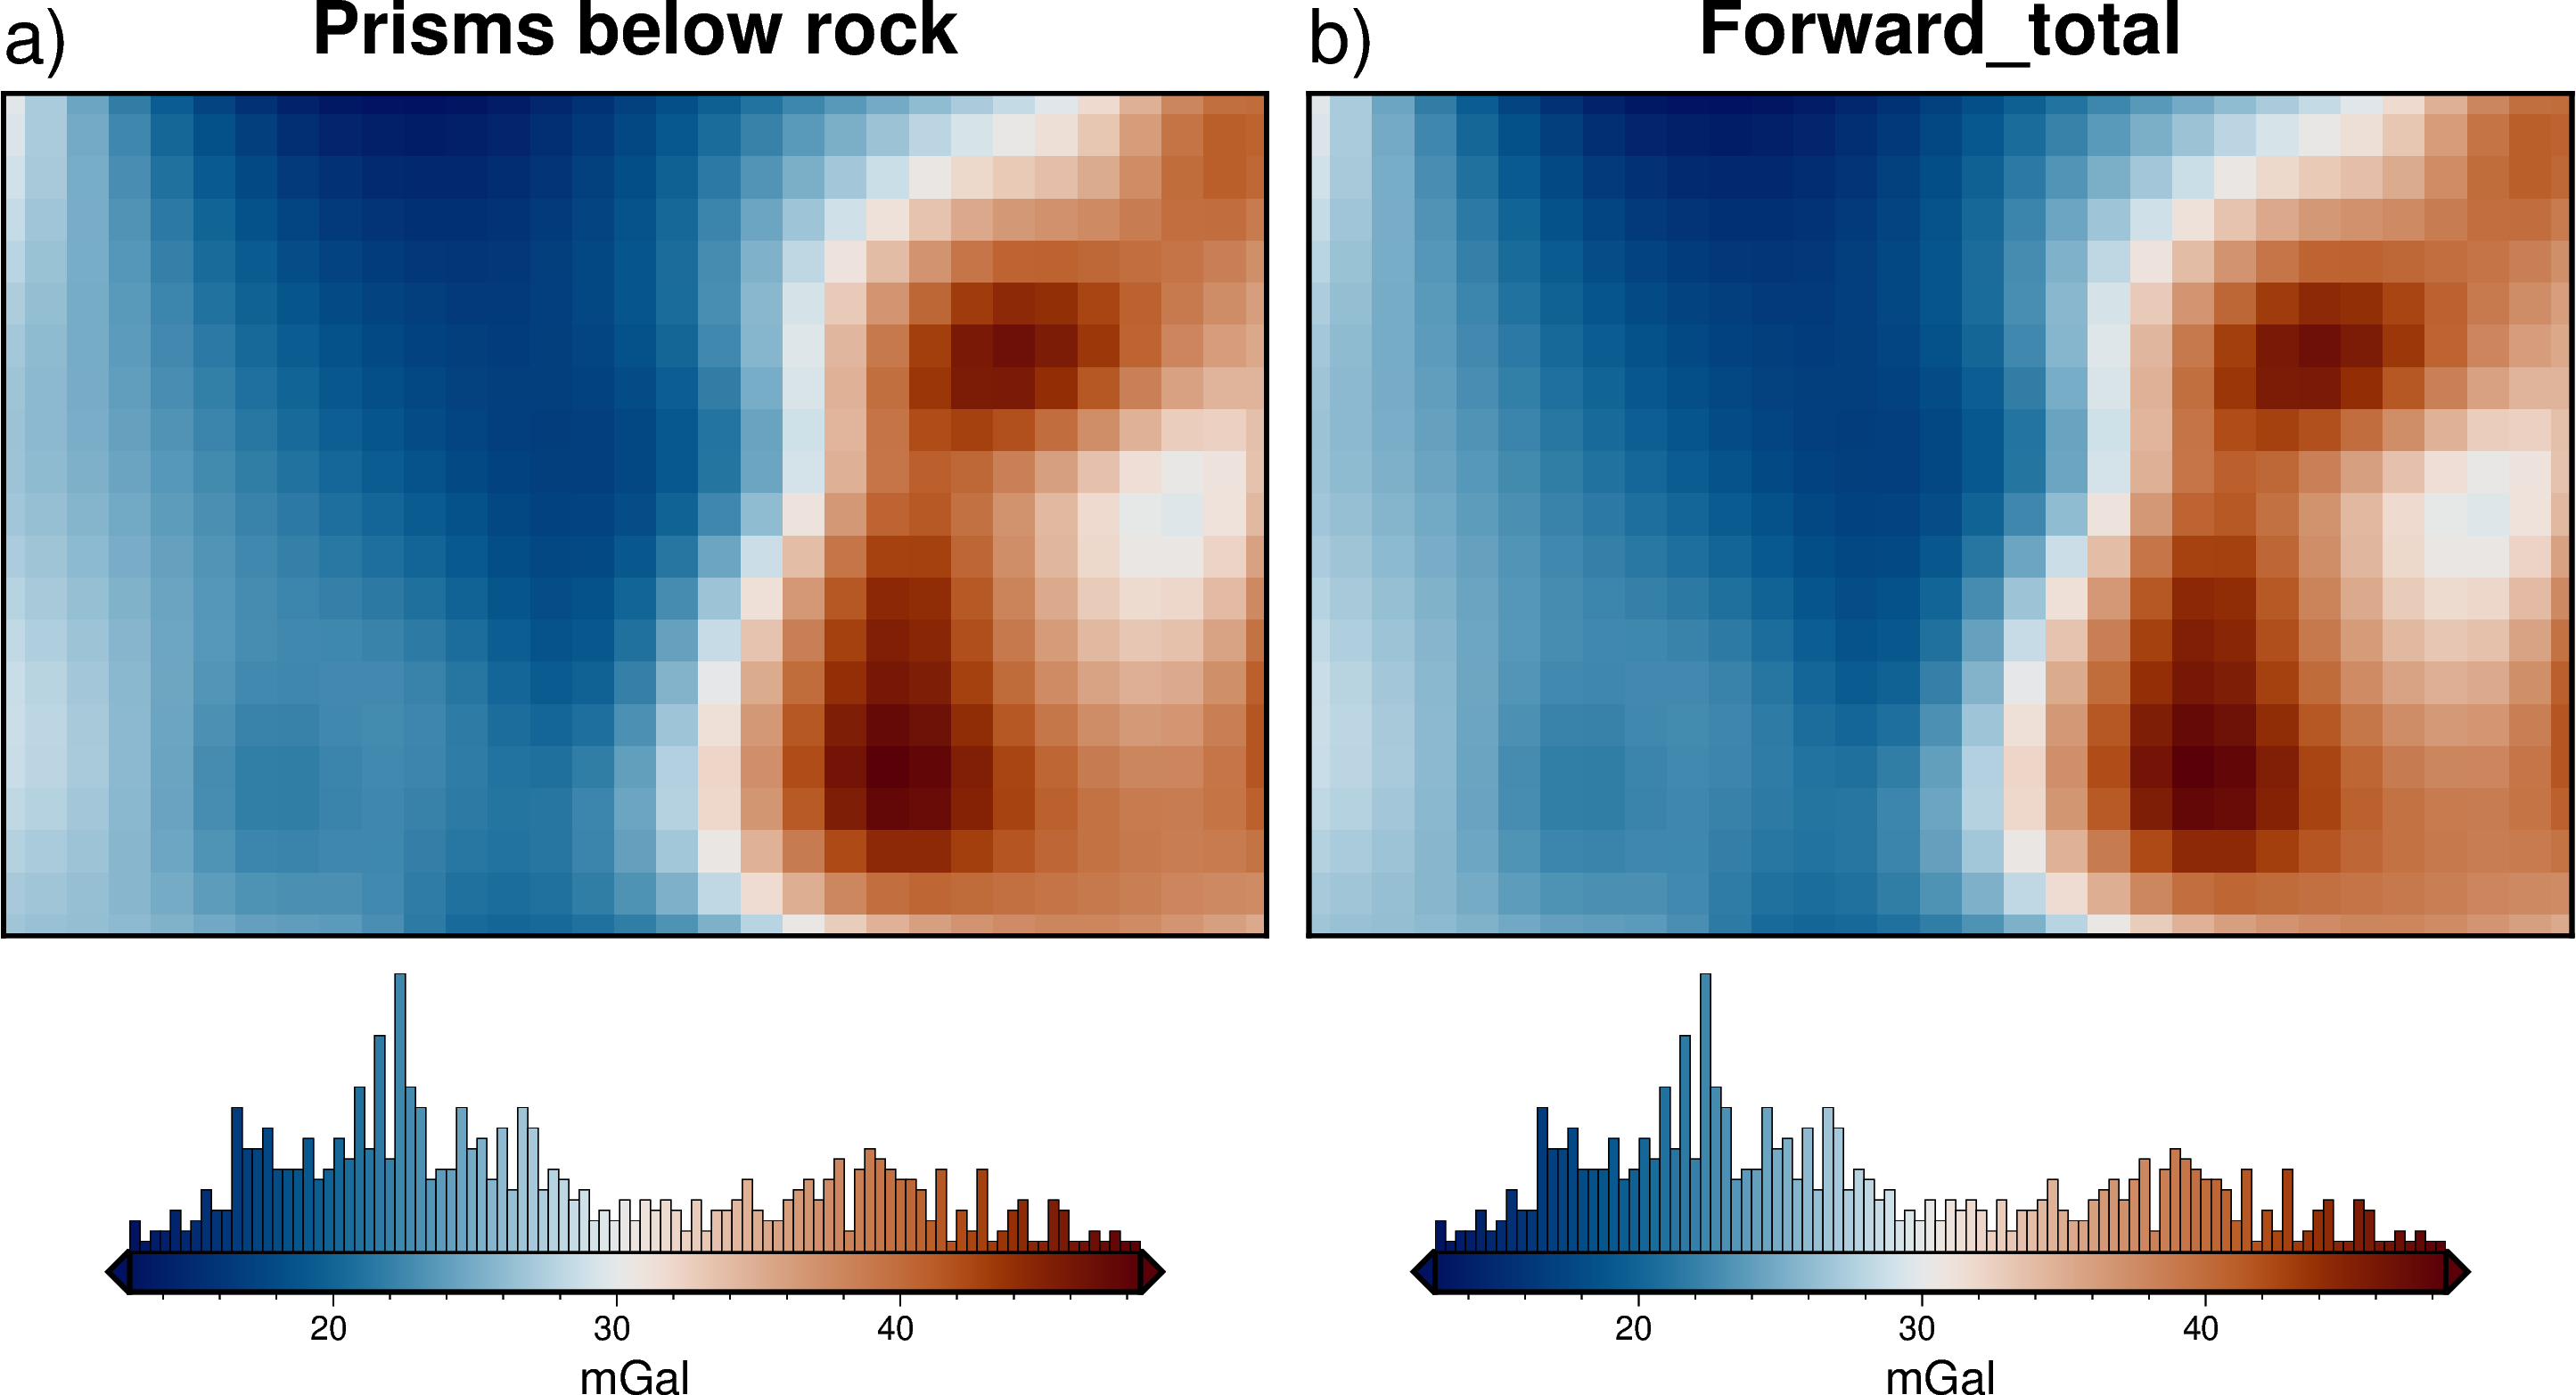

In [ ]:
grav_prisms_below_surface, df = inv_utils.forward_grav_of_prismlayer(
    [prisms_below_surface],
    observation_points,
    plot=True,
    names=["Prisms below rock"],
    # remove_mean=True,
    progressbar=True,
)

# Method e) Relative to reference level

In [ ]:
density_contrast = 2670 - 917

zref = bed.values.mean()
density = xr.where(bed >= zref, density_contrast, -density_contrast)

zref_prisms = inv_utils.grids_to_prisms(
    bed,
    zref,
    density=density,
    input_coord_names=["x", "y"],
)

# plotting.show_prism_layers(
#     [zref_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     # color_by='constant',
#     # log_scale=False,
#     clip_box=False,
#     zscale=20,
# )

  0%|                                                   | 0/651 [00:00<?, ?it/s]

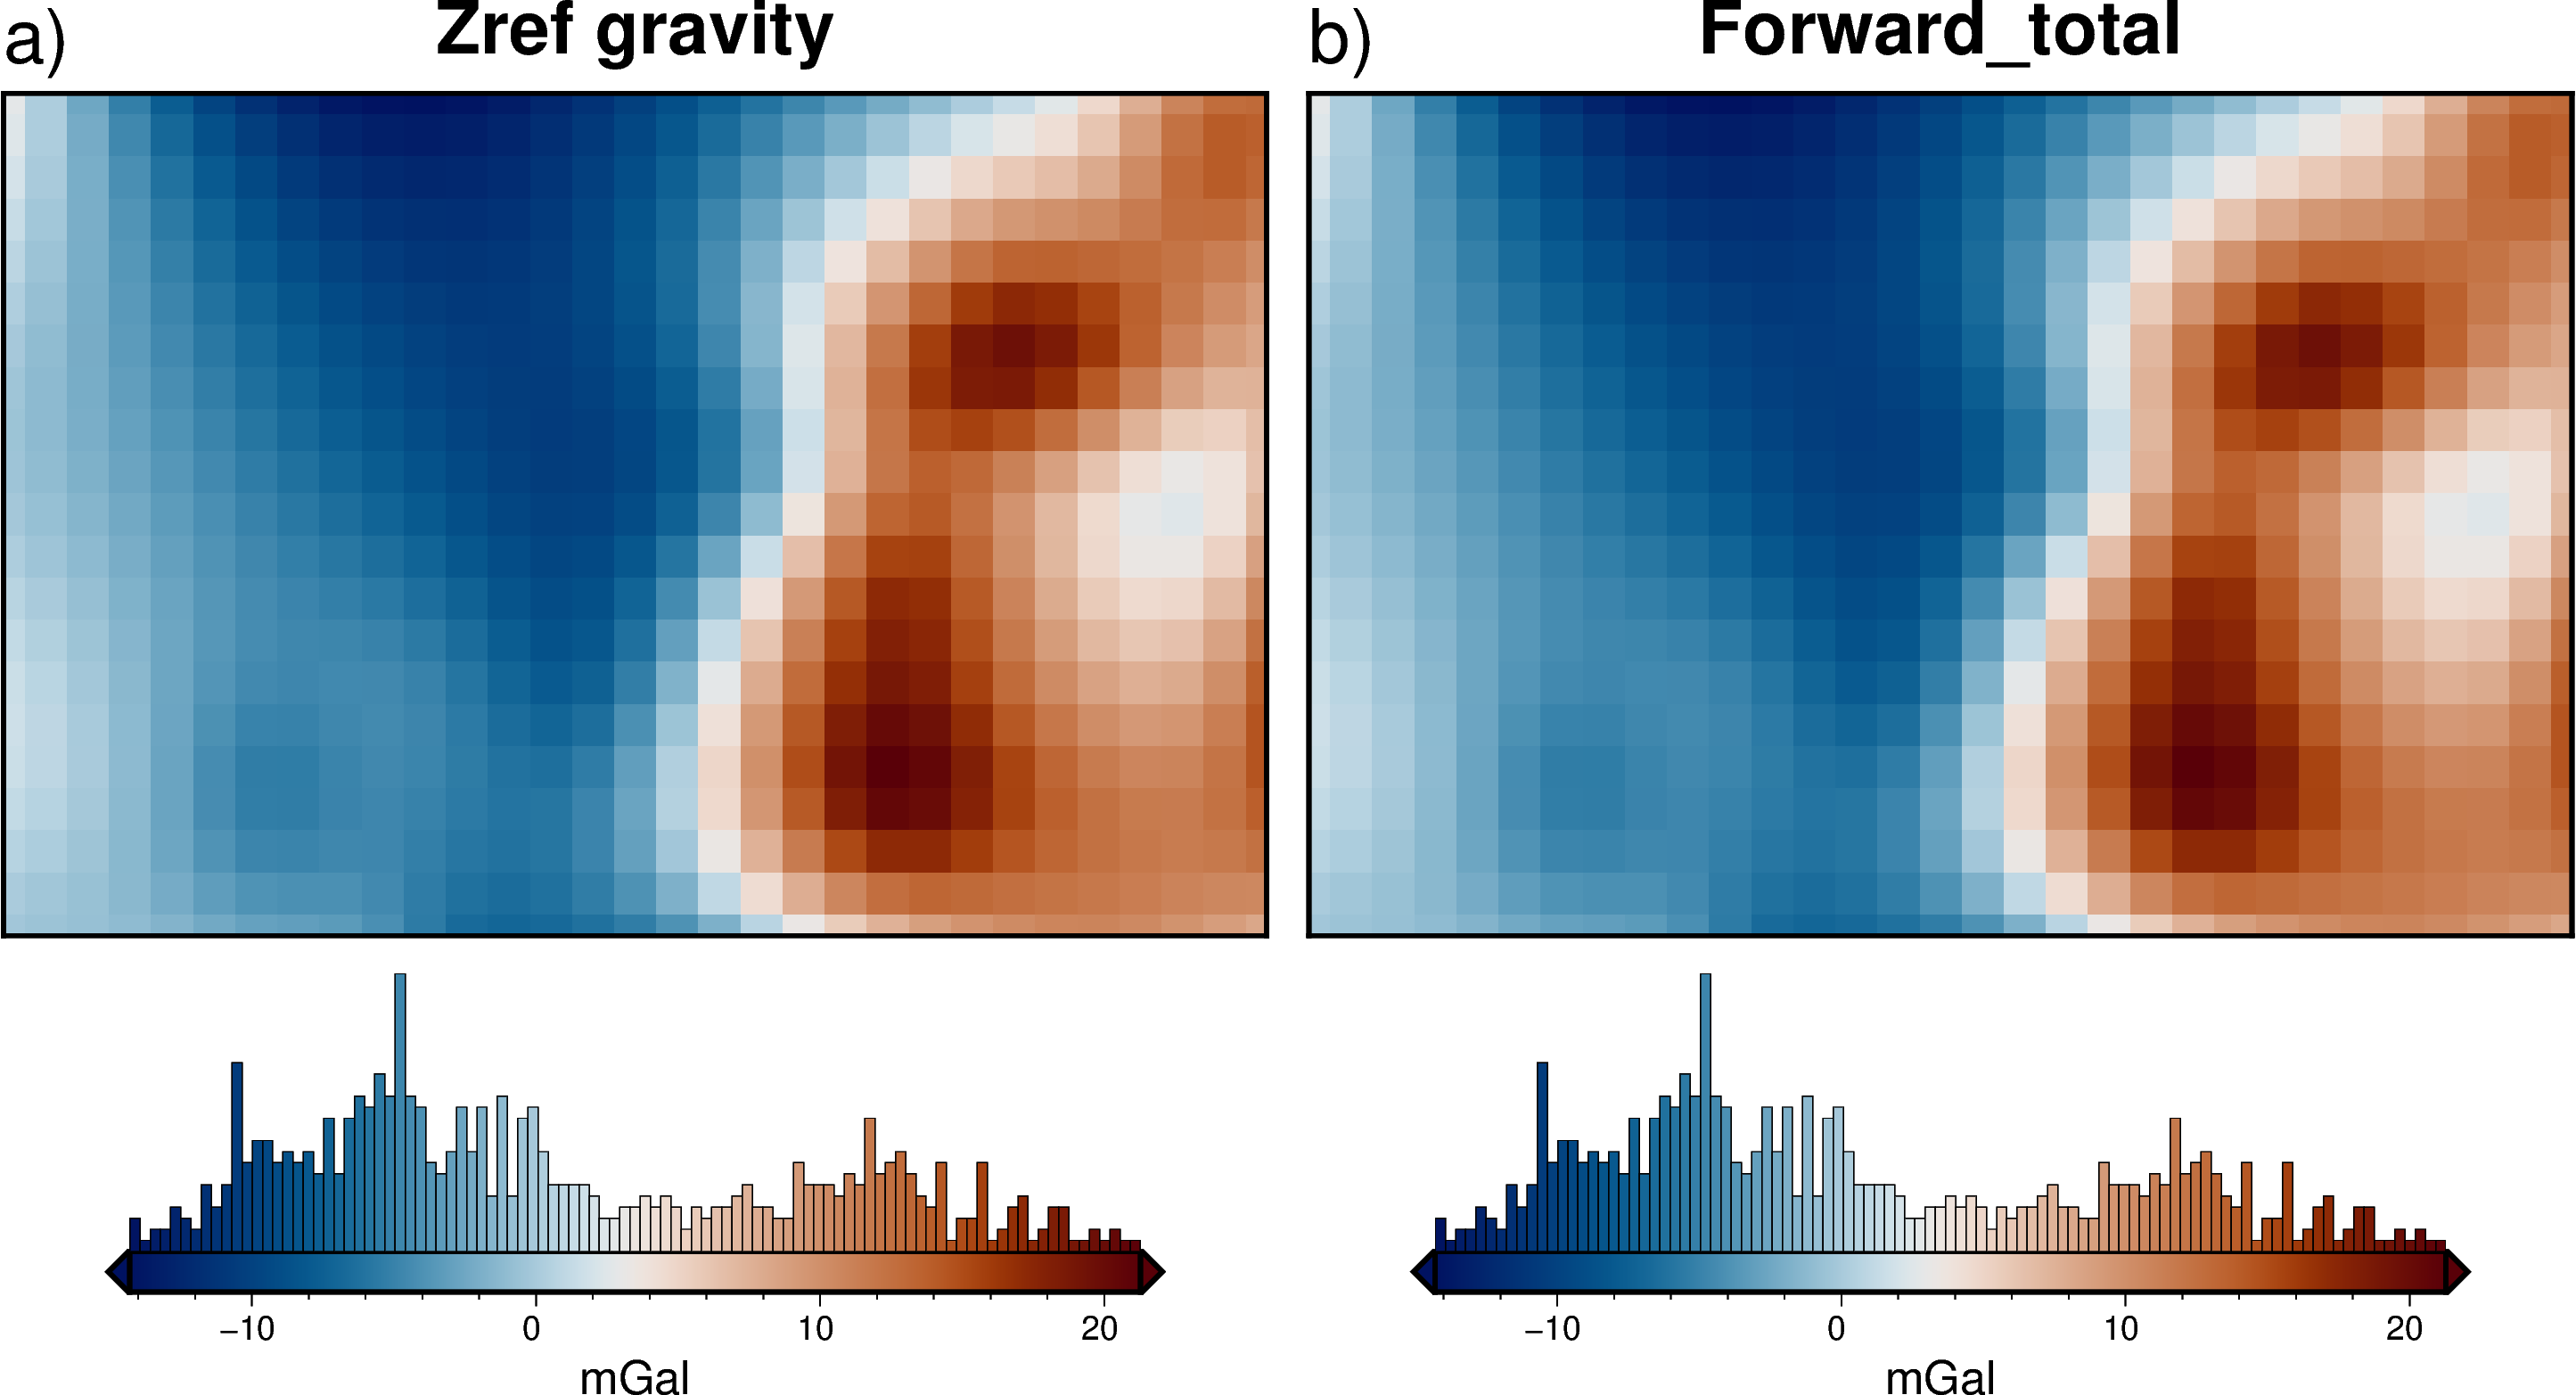

In [ ]:
zref_grav, df = inv_utils.forward_grav_of_prismlayer(
    [zref_prisms],
    observation_points,
    plot=True,
    names=["Zref gravity"],
    # remove_mean=True,
    progressbar=True,
)

## Compare forward gravities

In [ ]:
plot_type = "xarray"
# plot_type = 'pygmt'

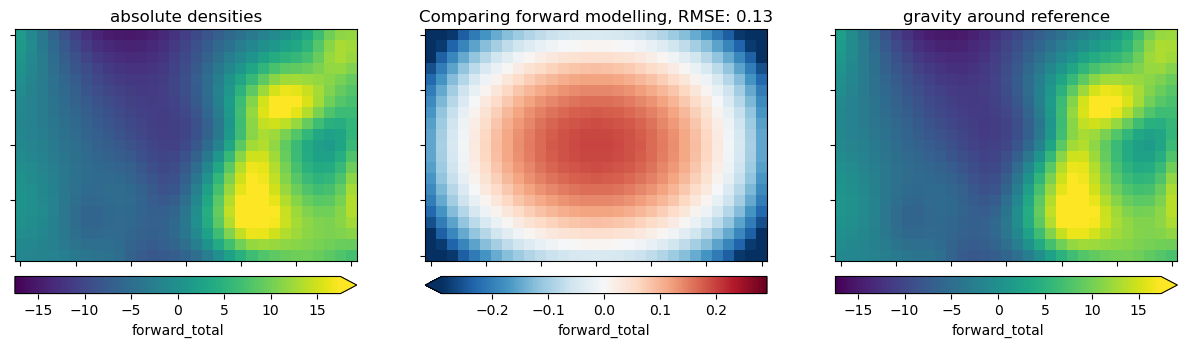

In [ ]:
grids = utils.grd_compare(
    forward_absolute.forward_total - np.mean(forward_absolute.forward_total),
    zref_grav.forward_total - np.mean(zref_grav.forward_total),
    plot=True,
    grid1_name="absolute densities",
    grid2_name="gravity around reference",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
    plot_type=plot_type,
    robust=True,
)

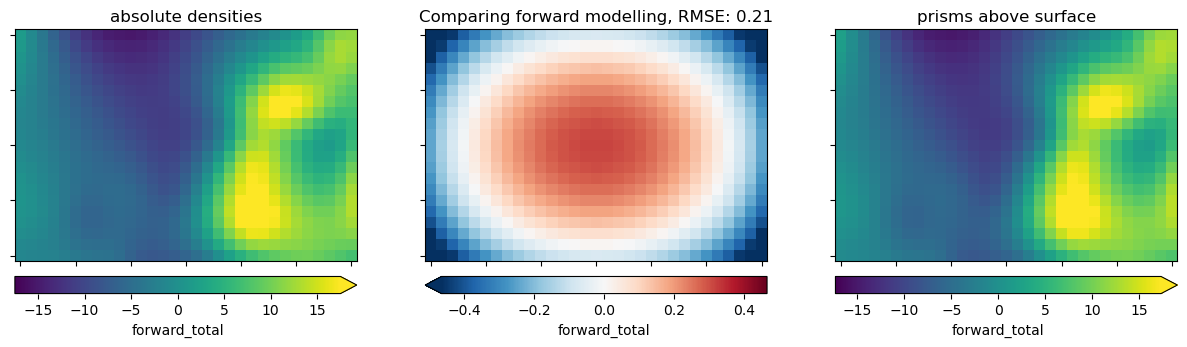

In [ ]:
grids = utils.grd_compare(
    forward_absolute.forward_total - np.mean(forward_absolute.forward_total),
    grav_prisms_above_surface.forward_total
    - np.mean(grav_prisms_above_surface.forward_total),
    plot=True,
    grid1_name="absolute densities",
    grid2_name="prisms above surface",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
    plot_type=plot_type,
    robust=True,
)

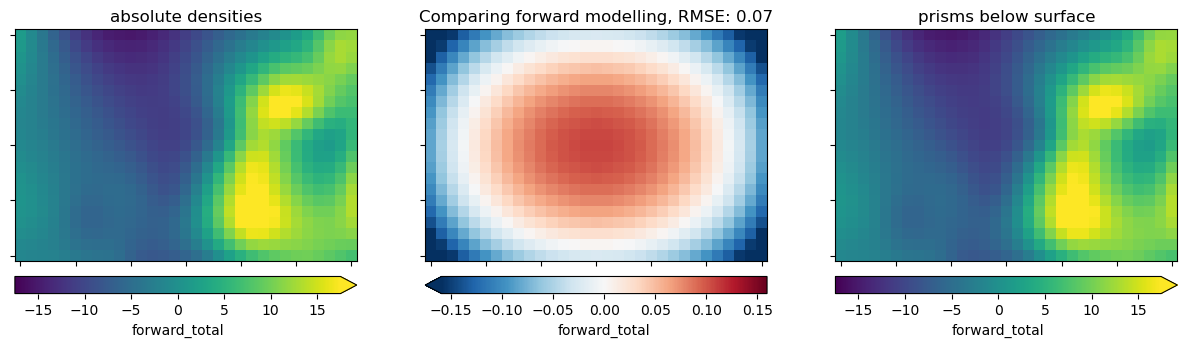

In [ ]:
grids = utils.grd_compare(
    forward_absolute.forward_total - np.mean(forward_absolute.forward_total),
    grav_prisms_below_surface.forward_total
    - np.mean(grav_prisms_below_surface.forward_total),
    plot=True,
    grid1_name="absolute densities",
    grid2_name="prisms below surface",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
    plot_type=plot_type,
    robust=True,
)